# Problem Statement

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

Each video is a sequence of 30 frames (or images).

## Objectives:

- Generator: The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

- Model: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

- Write up: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

# Gesture Recognition


In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime
import os
import matplotlib.pyplot as plt
import warnings


We Will set the random seed so that the results don't vary drastically.

In [3]:
warnings.filterwarnings('ignore')
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())
batch_size = 30

## Generator

This is one of the most important parts of the code. In the generator, we are going to pre-process the images as we have images of different dimensions (50 x 50, 70 x 70 and 120 x 120) as well as create a batch of video frames. The generator should be able to take a batch of videos as input without any error. Steps like cropping/resizing and normalization should be performed successfully.  We have to experiment with `img_idx`, `y`,`z` and normalization such that we get high accuracy.

In [5]:
def cropResize(image, y, z):
    h, w = image.shape

    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))

In [6]:
def normalizeImage(image):
    # applying normalization
    return image/255.0

In [7]:
def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

In [8]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

In [9]:
def getBatchData(source_path, t, batch, batch_size, img_tensor):
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape
            #and the conv3D will throw error if the inputs in a batch have different shapes

            # separate preprocessImage function is defined for cropping, resizing and normalizing images
            batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z)
            batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z)
            batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z)

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels

In [10]:
def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)

        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)

A video is represented above in the generator as (number of images, height, width, number of channels). We take this into consideration while creating the model architecture.

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [12]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 100, 100, 3]

# define image tensor size
img_tensor = getImgTensor(20)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]


In [13]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)

Source path =  datasets/Project_data/train ; batch size = 30
Source path =  datasets/Project_data/val ; batch size = 30


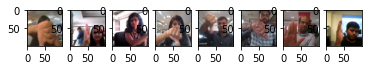

In [14]:
# plot generated sample images
fig, ax = plt.subplots(1,8)
ax[0].imshow(sample_val_batch_data[10,10,:,:,:])
ax[1].imshow(sample_val_batch_data[12,10,:,:,:])
ax[2].imshow(sample_val_batch_data[15,10,:,:,:])
ax[3].imshow(sample_val_batch_data[20,10,:,:,:])
ax[4].imshow(sample_val_batch_data[25,10,:,:,:])
ax[5].imshow(sample_val_batch_data[13,10,:,:,:])
ax[6].imshow(sample_val_batch_data[18,10,:,:,:])
ax[7].imshow(sample_val_batch_data[27,10,:,:,:])
plt.show()

## Model

Here we make the model using different functionalities that Keras provides. We must use `Conv3D` and `MaxPooling3D` for a 3D convolution model. We would also use `TimeDistributed` while building a Conv2D + RNN model. Also, the last layer is the softmax. We design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

Once we have written the model, the next step is to compile the model. When we print the summary of the model, we can see the total number of parameters we have to train.

In [15]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

In [16]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras import layers
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
#write your model here
def defineModel(img_tensor):
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    optimiser = 'adam' #Specify the optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = defineModel(img_tensor)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 96, 96, 16)    6016      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 48, 48, 16)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 8, 48, 48, 16)    64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 23, 23, 32)    0         
 3D)                                                             
                                                        

2024-05-15 11:30:42.782911: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-05-15 11:30:42.782984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


In [17]:
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [19]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_').replace('.','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
earlystop = EarlyStopping(monitor="val_loss", min_delta=0,patience=20,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

#callbacks_list = [LR]

In [20]:
def testBatchSize(batch_size, n_frames):
    img_tensor = getImgTensor(n_frames)
    print("Using frames as", img_tensor[0])
    global callbacks_list
    num_epochs = 3
    train_generator = generator(train_path, train_doc, batch_size, img_tensor)
    val_generator = generator(val_path, val_doc, batch_size, img_tensor)
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    model = defineModel(img_tensor)
    model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                callbacks=callbacks_list, validation_data=val_generator,
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Model 1

Model: "conv_3d1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 26, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 13, 48, 48, 16)   0         
 3D)                                                             
                                                                 
 batch_normalization_5 (Batc  (None, 13, 48, 48, 16)   64        
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 11, 46, 46, 32)    13856     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 11, 23, 23, 32)   0         
 3D)                                                             
                                                          

2024-05-15 11:31:05.273046: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


27/27 [==============================] - ETA: 0s - loss: 1.6046 - categorical_accuracy: 0.4299Source path =  datasets/Project_data/val ; batch size = 25

Epoch 00001: val_loss improved from inf to 7.64171, saving model to model_init_2024-05-1511_30_26_384870/model-00001-1.60458-0.42986-7.64171-0.23000.h5
27/27 [==============================] - 304s 12s/step - loss: 1.6046 - categorical_accuracy: 0.4299 - val_loss: 7.6417 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/15
27/27 [==============================] - ETA: 0s - loss: 1.1858 - categorical_accuracy: 0.5271
Epoch 00002: val_loss improved from 7.64171 to 3.78210, saving model to model_init_2024-05-1511_30_26_384870/model-00002-1.18581-0.52707-3.78210-0.26000.h5
27/27 [==============================] - 117s 4s/step - loss: 1.1858 - categorical_accuracy: 0.5271 - val_loss: 3.7821 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/15
27/27 [==============================] - ETA: 0s - loss: 1.3213 - categorical_accuracy

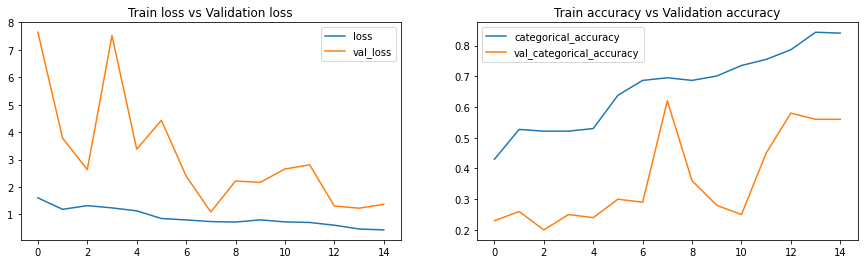

Max. Training Accuracy 0.8433048725128174
Max. Validaiton Accuracy 0.6200000047683716


In [21]:
n_frames = 30
num_epochs = 15
batch_size = 25

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model_1 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d1")
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_1.summary())

model_1_history = model_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None,workers=1, initial_epoch=0)
plotModelHistory(model_1_history)

#### Insights:

  - Number of Epochs =15; Batch size=25; Number of frames=30, Taking this values giving the good training and validation accuracy but not upto the mark.
    Lets try another model by changing the batch size, the number of frames and number of epochs.

Model: "conv_3d1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 16, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 8, 48, 48, 16)    0         
 3D)                                                             
                                                                 
 batch_normalization_10 (Bat  (None, 8, 48, 48, 16)    64        
 chNormalization)                                                
                                                                 
 conv3d_7 (Conv3D)           (None, 6, 46, 46, 32)     13856     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 6, 23, 23, 32)    0         
 3D)                                                             
                                                          

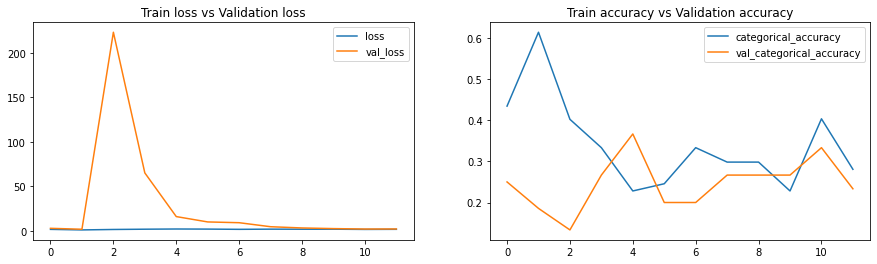

Max. Training Accuracy 0.6140350699424744
Max. Validaiton Accuracy 0.36666667461395264


In [22]:
#Model 2- 
n_frames = 20
num_epochs = 12
batch_size = 35

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model_2 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d1")
model_2.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_2.summary())

model_2_history = model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None,workers=1, initial_epoch=0)
plotModelHistory(model_2_history)

#### Insights:

- Number of Epochs =12; Batch size=35; Number of frames=20, Taking this values giving the good training value but not good in validation accuracy. Its clearly an overfit model. Lets try another model by changing the batch size, the number of frames and number of epochs.

## Model 3

Model: "conv_3d1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 26, 96, 96, 16)    6016      
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 13, 48, 48, 16)   0         
 3D)                                                             
                                                                 
 batch_normalization_15 (Bat  (None, 13, 48, 48, 16)   64        
 chNormalization)                                                
                                                                 
 conv3d_10 (Conv3D)          (None, 11, 46, 46, 32)    13856     
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 11, 23, 23, 32)   0         
 g3D)                                                            
                                                          

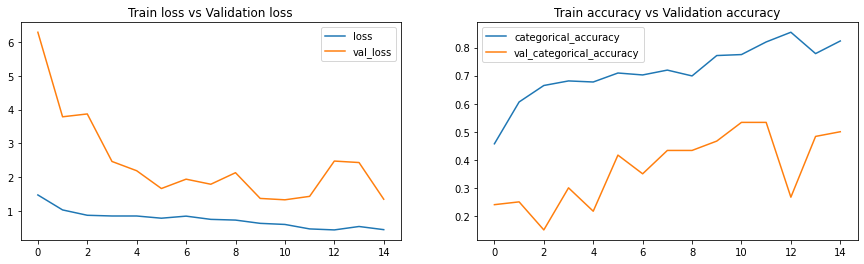

Max. Training Accuracy 0.85467129945755
Max. Validaiton Accuracy 0.5333333611488342


In [23]:
#Model 3- 
n_frames = 30
num_epochs = 15
batch_size = 40


img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model_3 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d1")
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_3.summary())

model_3_history = model_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None,workers=1, initial_epoch=0)
plotModelHistory(model_3_history)

#### Insights:

- Number of Epochs =15; Batch size=40; Number of frames=30, By incresing batch size and no. of frames increases the training and validation accuracy.

# conv 2D model

## Model 1

Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 100, 100, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 100, 100, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 50, 50, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 50, 50, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 50, 50, 32)  

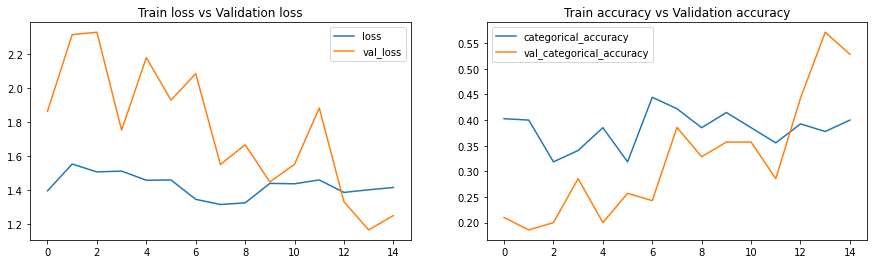

Max. Training Accuracy 0.4444444477558136
Max. Validaiton Accuracy 0.5714285969734192


In [24]:
#Switching Model architecture to Conv2D+LSTM

n_frames = 20
num_epochs = 15
batch_size = 15

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model1 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())

model1_history = model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None,workers=1,  initial_epoch=0)
plotModelHistory(model1_history)


#### Insights:

Conv2D+LSTM model 1 is clearly overfitting we will change the number of frames, no of epochs and batch size and check.

### Model 2

Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 100, 100, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 100, 100, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 50, 50, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 50, 50, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 50, 50, 32)  

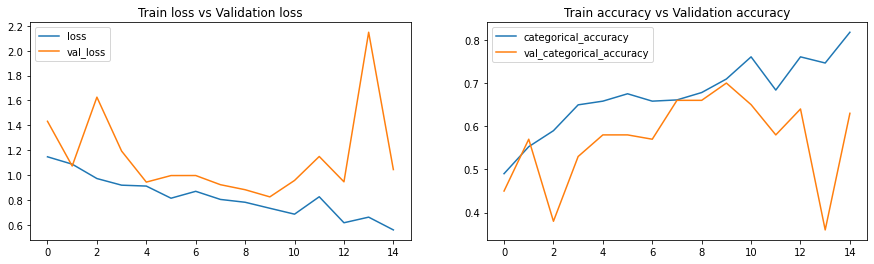

Max. Training Accuracy 0.8176637887954712
Max. Validaiton Accuracy 0.699999988079071


In [25]:
#Switching Model architecture to Conv2D+LSTM

n_frames = 20
num_epochs = 15
batch_size = 25

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model2 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())

model1_history = model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None,workers=1,  initial_epoch=0)
plotModelHistory(model1_history)

#### Insigths:

by increasing batch size in this model giving a very good training and validation accuracy.

# model 3

Model: "conv_2d_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_32 (TimeDi  (None, 20, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 20, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 20, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 20, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 20, 50, 50, 32)  

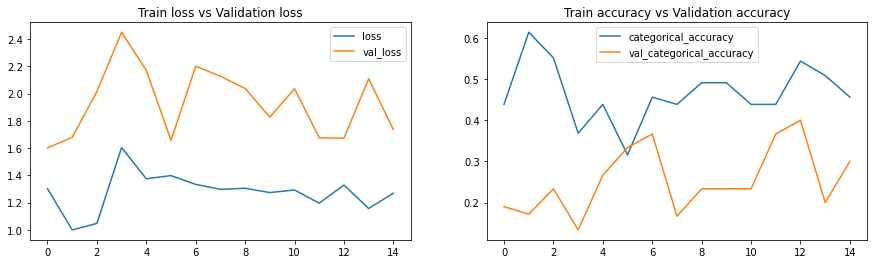

Max. Training Accuracy 0.6140350699424744
Max. Validaiton Accuracy 0.4000000059604645


In [26]:
#Switching Model architecture to Conv2D+LSTM

n_frames = 20
num_epochs = 15
batch_size = 35

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model3 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model3.summary())

model3_history = model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
            callbacks=callbacks_list, validation_data=val_generator,
            validation_steps=validation_steps, class_weight=None,workers=1,  initial_epoch=0)
plotModelHistory(model3_history)

#### Insights:

- In this model we only increase the batch size so the training and validation accuracy decrease but giving a nice model.

## Observations:

•	It was observed that with the increase of Number of trainable parameters, the models start taking  much more time for training.

•	Batch size Vs GPU memory: A large batch size can throw GPU Out of memory error , and thus here we had to apply different batch sizes till we were able to arrive at an optimal value of the batch size which our GPU could support (RTX 5000 in Jarvis Labs).

•	We also found out that the middle frames gives us most of the information and because the train images were chosen so carefully, data augmentation was not required though left-right flipping and zoom, slight rotation could have been done.

•	Increasing the batch size leads to decrease in the training time but this also has a negative impact on the model accuracy. This made us realise that there is always a trade-off here on basis of priority. If we want our model to be ready in a shorter time span, choose larger batch size or for more accuracy we can choose smaller batch size.

•	Conv3D had better performance than CNN2D+LSTM based model with GRU cells. As per our understanding, this is something which depends on the kind of data we used, the architecture we developed and the hyper-parameters we chose.

•	Transfer learning boosted the overall accuracy of the model. We made use of the MobileNet Architecture due to its light-weight design and high-speed performance coupled with low maintenance as compared to other well-known architectures like VGG16, AlexNet, GoogleNet etc.


# Model Overview: 

#### Conv3D:

- conv_3d1_model:

Model Type - conv3D,   Number of parameters - 9,006,245, Frames/ Batch_size - 30/25, Epochs - 15, Best Validation accuracy - 62.00%,
Corresponding Training accuracy - 84.33%.

Observations: Training and validation Accuracy are good but not up to the mark. Next we can try to increase 
    the batch size and slight decreasing the frames.


- conv_3d2_model:

Model Type - conv3D,   Number of parameters - 4,050,085, Frames/ Batch_size - 20/35, Epochs - 12, Best Validation accuracy - 36.66%,
Corresponding Training accuracy - 61.4%.

Observations: Training accuracy is bit well but the validation Accuracy is too low. Next we can try to increase the frames and batch size.


- conv_3d3_model: 

Model Type - conv3D,   Number of parameters - 9,006,245, Frames/ Batch_size - 30/40, Epochs - 15, Best Validation accuracy - 53.33%,
Corresponding Training accuracy - 85.75%.

Observations: The difference between training accuracy and testing increased very much showing overfitting of the model.




##### Time Distributed (CNN + LSTM):

##### Conv 2D:


- CNN_RNN_1:

Model Type - TimeDistributed,   Number of parameters - 3,084,133, Frames/ Batch_size - 20/15, Epochs - 15, 
Best Validation accuracy - 57.14%, Corresponding Training accuracy - 44.45%.

Observations: We tried a basic CNN 2d with RNN LSTM and we didn’t get good accuracy and sees overfit. Model not learning much info in training, not performing well in validation also.
Increasing the Batch size of the model and trying again.


- CNN_RNN_2:

Model Type - TimeDistributed,   Number of parameters - 3,084,133, Frames/ Batch_size - 20/25, Epochs - 15,
Best Validation accuracy - 69.99%, Corresponding Training accuracy - 81.76%.

Observations: With the increase in batch size we can see improve in training accuracy and validation 
             accuracy but the validation accuracy didn’t improve much. Still, this seems to be overfit.


- CNN_RNN_3:

Model Type - TimeDistributed,   Number of parameters - 3,084,133, Frames/ Batch_size - 20/35, Epochs - 15,
Best Validation accuracy - 40.00%, Corresponding Training accuracy - 61.40%.

Observations: With the increase in batch size we can’t see improvement in training accuracy and validation accuracy. 

